### COMPARING MODELS

In [1]:
# IMPORT EVERYTHING
#from Architectures.AE_ADJ import AE  # for some reason importing this makes it not work? (reconstructs everything around the brain somehow)
from Architectures.AE_ADJ_v2 import AE  # for some reason importing this makes it not work? (reconstructs everything around the brain somehow)

from Data.load import load, load_middle_slices
from Visualizations.latent_space_projections import plot_multiple_datasets
from Visualizations.plots import plot_middle_slices_in_range, plot_models_training_time, compare_models_loss_history, plot_images, compare_models_reconstruction
from Metrics.metrics_tf import MSE_loss, NMSE_loss, NRMSE_loss, SSIM_loss
from Metrics.metrics import NMSE, SSIM, NRMSE, MSE

from sklearn.cluster import SpectralClustering
from scipy.stats import f_oneway
from sklearn.metrics import silhouette_score, adjusted_rand_score
#from sklearn.cluster import KMeans

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import layers, Model, activations, regularizers
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

from skimage.metrics import structural_similarity as ssim

import umap
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import pandas as pd
import seaborn as sns
import glob
import tensorflow as tf
import time
import math
import nibabel as nib
import json
from tqdm import tqdm

c:\Users\kiran\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
groups = {}
for group in tqdm(["CN","MCI","AD"],"Opening faster"):
    groups[group]=np.load(open(f"Data/D2-{group}.npy","br"))

Opening faster: 100%|██████████| 3/3 [00:00<00:00, 77.51it/s]


In [86]:
urls = [ #xd
    r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_repo_2D_mse\epoch_177",
    r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_repo_2D_ssim\epoch_142",
    r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_repo_2D_VAE_mse\epoch_168",
    r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_repo_2D_VAE_ssim\epoch_228",
    
    r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_alcoholism_paper_2D_mse\epoch_295",
    r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_alcoholism_paper_2D_ssim\epoch_185",
    r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_alcoholism_paper_2D_vae_mse\epoch_162",
    r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_alcoholism_paper_2D_vae_ssim\epoch_138",
    
    r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_frontiers_paper_2d_mse\epoch_215",
    r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_frontiers_paper_2d_ssim\epoch_152",
    r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_frontiers_paper_2d_vae_mse\epoch_300",
    r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_frontiers_paper_2d_vae_ssim\epoch_186",
    
    r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_unsupervised_anomaly_2d_mse\epoch_256",
    r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_unsupervised_anomaly_2d_ssim\epoch_166",
    r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_unsupervised_anomaly_2d_vae_mse\epoch_403",
    r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_unsupervised_anomaly_2d_vae_ssim\epoch_165",
]
#urls = [
    #r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\custom_simplest_model\epoch_387",
    #r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_frontiers_paper_2d_mse_lrE\epoch_199",
    #r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_frontiers_paper_2d_mse_lrED\epoch_197"
#]
models_list = [AE.open(u) for u in urls]

Models loaded successfully.
Models loaded successfully.

Models loaded successfully.
Models loaded successfully.
Models loaded successfully.
Models loaded successfully.
Models loaded successfully.
Models loaded successfully.
Models loaded successfully.
Models loaded successfully.
Models loaded successfully.
Models loaded successfully.
Models loaded successfully.
Models loaded successfully.
Models loaded successfully.
Models loaded successfully.


In [88]:
"""
def find_clusters(data, n_clusters=3):
    "
    Perform clustering on MRI latent space data using Spectral Clustering and calculate p-values.
    
    Parameters:
    data (numpy.ndarray): A matrix of shape (n_samples, m_features).
    n_clusters (int): Number of clusters to form.
    
    Returns:
    tuple: Cluster labels for each sample, p-values for samples.
    "
    
    # Perform Spectral Clustering
    #spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=10) # random_state=42
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='rbf', gamma=0.1)

    # import warnings
    # with warnings.catch_warnings():
    #     warnings.filterwarnings("ignore", message="Graph is not fully connected*")
    #     spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
    #     labels = spectral.fit_predict(data)

    labels = spectral.fit_predict(data)
    
    # Calculate p-values for each feature using ANOVA
    p_values_samples = []
    for i in range(data.shape[1]):
        feature_data = [data[labels == cluster, i] for cluster in range(n_clusters)]
        f_stat, p_value = f_oneway(*feature_data)
        p_values_samples.append(p_value)
    
    return labels, np.array(p_values_samples)

def Silhouette(data, labels, true_labels=[]):
    return silhouette_score(data, labels)

def Inertia(data, labels, true_labels=[]):
    # Inertia calculated using the labels from SpectralClustering
    inertia = 0
    n_clusters = len(set(labels))
    for i in range(n_clusters):
        cluster_data = data[labels == i]
        cluster_center = cluster_data.mean(axis=0)
        inertia += ((cluster_data - cluster_center) ** 2).sum()
    return inertia

def ARI(data, labels, true_labels):
    return adjusted_rand_score(true_labels, labels)

def compare_models(models_list, groups, reconstruction_metrics, clustering_metrics, n_runs=20):
    # To run this function
    # 1. add name to each model, model.name="something"
    # 2. add .VAE_model = True to your vae models, .VAE_model = false to others
    # 3. add in the encode(), decode() functions (you can copy from ae_adj_v2.py), or you can modify compare_models to your likings
    
    metric_results = []
    group_labels = {"CN": 0, "AD": 1, "MCI": 2}
    true_labels = []
    
    for label, image in groups.items():
        true_labels.extend([group_labels[label]] * image.shape[0])

    for i, model in enumerate(models_list):
        model_result = {"Model": model.name}

        for label, image in groups.items():
            latent = model.encode(image)
            recon = model.autoencode(image)

            for recon_metric in reconstruction_metrics:
                metric_name = f"{label}_{recon_metric.__name__}"
                metric_value = recon_metric(image, recon) #.numpy()
                model_result[metric_name] = metric_value
                print(f"Reconstruction metric computed: {metric_name}")

        combined_data = np.concatenate(list(groups.values()), axis=0)
        combined_data_scaled = StandardScaler().fit_transform(combined_data.reshape(-1, combined_data.shape[-1])).reshape(combined_data.shape)
        
        latent = model.encode(combined_data_scaled)
        if model.VAE_model:
            latent = latent[2]

        # After collecting all the UMAP runs, now calculate the average for each metric
        for clustering_metric in clustering_metrics:
            metric_name = clustering_metric.__name__

            # Initialize lists to store metric values for each run
            metric_values = []

            for i in range(n_runs):
                cluster_labels, _ = find_clusters(latent) #(dim_red_latent_all_runs[i])
                
                # Compute the clustering metric for each run
                # metric_value = clustering_metric(dim_red_latent_all_runs[i], cluster_labels, true_labels)
                metric_value = clustering_metric(latent, cluster_labels, true_labels)
                metric_values.append(metric_value)

            # Calculate the average metric across all runs
            average_metric_value = np.mean(metric_values)
            print("--avrg", metric_values)

            # Store the averaged metric in the model results
            model_result[metric_name] = average_metric_value
            
        metric_results.append(model_result)

    return pd.DataFrame(metric_results)
"""

def Silhouette(data, labels, true_labels=[]):
    return silhouette_score(data, labels)

def Inertia(data, labels, true_labels=[]):
    # Inertia calculated using the labels from SpectralClustering
    inertia = 0
    n_clusters = len(set(labels))
    for i in range(n_clusters):
        cluster_data = data[labels == i]
        cluster_center = cluster_data.mean(axis=0)
        inertia += ((cluster_data - cluster_center) ** 2).sum()
    return inertia

def ARI(data, labels, true_labels):
    return adjusted_rand_score(true_labels, labels)


def Cluster_accuracy(data, labels, true_labels):
    from sklearn.metrics import accuracy_score
    from scipy.optimize import linear_sum_assignment
    import numpy as np

    def cluster_accuracy(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        D = max(y_pred.max(), y_true.max()) + 1
        cost_matrix = np.zeros((D, D), dtype=np.int64)

        for i in range(len(y_pred)):
            cost_matrix[y_pred[i], y_true[i]] += 1

        row_ind, col_ind = linear_sum_assignment(cost_matrix.max() - cost_matrix)
        total = sum([cost_matrix[r, c] for r, c in zip(row_ind, col_ind)])
        return total / len(y_pred)

    acc = cluster_accuracy(true_labels, labels)
    print(f"Cluster match accuracy: {acc:.2f}")
    return acc



def compare_models(models_list, groups, reconstruction_metrics, clustering_metrics, n_runs=20):

    group_labels = {"CN": 0, "AD": 1, "MCI": 2}
    metric_results = []
    true_labels = []

    for label, image in groups.items():
        true_labels.extend([group_labels[label]] * image.shape[0])

    for i, model in enumerate(models_list):
        model_result = {"Model": model.name}

        for label, image in groups.items():
            latent = model.encode(image)
            recon = model.autoencode(image)

            for recon_metric in reconstruction_metrics:
                metric_name = f"{label}_{recon_metric.__name__}"
                metric_value = recon_metric(image, recon) #.numpy()
                model_result[metric_name] = metric_value
                print(f"Reconstruction metric computed: {metric_name}")

        combined_data = np.concatenate(list(groups.values()), axis=0)
        
        latent = model.encode(combined_data)
        if model.VAE_model:
            latent = latent[2]
        
        latent = StandardScaler().fit_transform(latent)
        
        # Run this shit several times to get the average result for UMAP and clustering, gosh
        dim_red_latent_all_runs = []
        pred_labels = []
        for i in range(n_runs):
            #Run UMAP with a different random state each time
            dim_red_latent = umap.UMAP(n_components=2).fit_transform(latent) #, random_state=i
            dim_red_latent_all_runs.append(dim_red_latent)
            
            # Two stochastic processes that interact can be calculated in the same pipeline
            #labels = SpectralClustering(n_clusters=3, affinity='rbf', gamma=1).fit_predict(dim_red_latent)
            labels = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', n_neighbors=25, assign_labels='kmeans').fit_predict(latent)

            pred_labels.append(labels)
        
        print("umap finished, calculating clustering metrics")

        for clustering_metric in clustering_metrics:
            metric_name = clustering_metric.__name__
            metric_values = []
            for i in range(n_runs):
                metric_value = clustering_metric(dim_red_latent_all_runs[i], pred_labels[i], true_labels)
                metric_values.append(metric_value)

            #model_result[metric_name] = str(np.mean(metric_values)) + "+-" + str(np.std(metric_values))
            
            avg = np.mean(metric_values)
            std = np.std(metric_values)
            #print(std)
            # Format: 2 decimals for float metrics, 0 for large numbers like inertia
            if avg > 1000:
                formatted = f"{avg:,.0f} ± {std:,.0f}"
            else:
                formatted = f"{avg:.2f} ± {std:.2f}"

            model_result[metric_name] = formatted


        metric_results.append(model_result)

    return pd.DataFrame(metric_results)

In [89]:
res = compare_models(models_list, groups, 
    reconstruction_metrics=[SSIM], 
    clustering_metrics=[Silhouette, Inertia, ARI, Cluster_accuracy], 
    n_runs=10)
res

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
Reconstruction metric computed: CN_SSIM
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Reconstruction metric computed: MCI_SSIM
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Reconstruction metric computed: AD_SSIM
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step
umap finished, calculating clustering metrics
Cluster match accuracy: 0.45
Cluster match accuracy: 0.45
Cluster match accuracy: 0.45
Cluster match accuracy: 0.45
Cluster match accuracy: 0.45
Cluster match accuracy: 0.45
Cluster match accuracy: 0.45
Cluster match accuracy: 0.45
Cluster match accuracy: 0.45
Cluster match accuracy: 0.45
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
Reconstruction metric compute

,Model,CN_SSIM,MCI_SSIM,AD_SSIM,Silhouette,Inertia,ARI,Cluster_accuracy
0,public_repo_2D_mse,0.789940,0.643849,0.624784,0.24 ± 0.01,"15,552 ± 1,432",0.03 ± 0.00,0.45 ± 0.00
1,public_repo_2D_ssim,0.794520,0.618682,0.623883,0.29 ± 0.01,"17,895 ± 826",0.20 ± 0.00,0.62 ± 0.00
2,public_repo_2D_VAE_mse,0.556171,0.440265,0.455895,-0.01 ± 0.01,"3,802 ± 125",-0.00 ± 0.00,0.35 ± 0.00
3,public_repo_2D_VAE_ssim,0.591872,0.479454,0.490486,-0.01 ± 0.01,"3,729 ± 87",0.00 ± 0.00,0.36 ± 0.00
4,public_alcoholism_paper_2D_mse,0.727525,0.585175,0.565684,0.32 ± 0.01,"10,694 ± 172",0.06 ± 0.00,0.58 ± 0.00
5,public_alcoholism_paper_2D_ssim,0.738596,0.596903,0.584128,0.15 ± 0.01,"17,050 ± 1,149",0.00 ± 0.00,0.46 ± 0.00
6,public_alcoholism_paper_2D_VAE_mse,0.411349,0.326335,0.339864,-0.02 ± 0.01,"3,888 ± 116",-0.00 ± 0.00,0.34 ± 0.00
7,public_alcoholism_paper_2D_VAE_ssim,0.346219,0.312985,0.327784,-0.02 ± 0.00,"3,795 ± 52",0.00 ± 0.00,0.35 ± 0.00
8,public_frontiers_paper_2d_mse,0.846719,0.679626,0.660610,0.28 ± 0.01,"15,456 ± 1,947",0.27 ± 0.00,0.64 ± 0.00
9,public_frontiers_paper_2d_ssim,0.840298,0.646676,0.646111,0.35 ± 0.01,"18,532 ± 1,513",0.30 ± 0.00,0.72 ± 0.00


In [46]:
res.to_feather("model_results_std2.feather")

In [47]:
#res.to_feather("model_results_std.feather")
#c = pd.read_feather("model_results.feather")
#c2 = pd.read_feather("model_results2.feather")
#print(display(c2))
#print(display(c))
#res.Model[6] = "public_alcoholism_paper_2D_VAE_mse"
#res.Model[7] = "public_alcoholism_paper_2D_VAE_ssim"
#res.to_feather("model_results_std.feather")
k = pd.read_feather("model_results_std2.feather")
#k["Training_loss_function"] = "mse" if "MSE" in k[Model] else "SSIM"
#k["VAE"] = "True" if "vae" in k[Model] else "False"

k["LossFN"] = k["Model"].str.contains("MSE", case=False).map({True: "mse", False: "SSIM"})
k["VAE"] = k["Model"].str.contains("vae", case=False).map({True: "True", False: "False"})
#k["Model"] = k["Model"].replace("_mse","").replace("_vae","")
k["Model"] = k["Model"].replace(r"_mse|_vae|_VAE|_ssim", "", regex=True)

k["Model"] = k["Model"].replace(r"public_repo_2D", "public_repo", regex=True)
k["Model"] = k["Model"].replace(r"public_alcoholism_paper_2D", "alcoholism_paper", regex=True)
k["Model"] = k["Model"].replace(r"public_frontiers_paper_2d", "frontiers_paper", regex=True)
k["Model"] = k["Model"].replace(r"public_unsupervised_anomaly_2d", "anomaly_paper", regex=True)
k.rename(columns={"Model": "2D model"}, inplace=True)


k = k[["2D model","LossFN","VAE","CN_SSIM","MCI_SSIM","AD_SSIM","Silhouette","Inertia","Cluster_accuracy"]]
k
#print(k.to_latex(index=False, ))

,2D model,LossFN,VAE,CN_SSIM,MCI_SSIM,AD_SSIM,Silhouette,Inertia,Cluster_accuracy
0,custom_simplest_model,SSIM,False,0.876875,0.709927,0.688797,0.50 ± 0.06,"17,265 ± 1,719",0.63 ± 0.00
1,frontiers_paper_lrED,mse,False,0.844837,0.686797,0.670675,0.65 ± 0.07,"21,054 ± 2,790",0.63 ± 0.00


In [ ]:
# Assuming the DataFrames are named df1 and df2

sim = c2.iloc[[0]]
pub_lr = c2.iloc[[2]]
pub_lr["Model"] = "public_frontiers_paper_2d_mse_lr"
pub_mse = c.iloc[[8]]

# Combine the subsets (if needed, otherwise you can keep them separate)
result = pd.concat([pub_mse, pub_lr, sim])
result_reset = result.reset_index(drop=True)
result_reset

C:\Users\kiran\AppData\Local\Temp\ipykernel_11160\3031806272.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pub_lr["Model"] = "public_frontiers_paper_2d_mse_lr"


,Model,CN_SSIM,MCI_SSIM,AD_SSIM,Silhouette,Inertia,ARI
0,public_frontiers_paper_2d_mse,0.846719,0.679626,0.660610,0.563119,22830.541397,0.035934
1,public_frontiers_paper_2d_mse_lr,0.844837,0.686797,0.670675,0.627846,19072.040731,0.034718
2,custom_simplest_model,0.876875,0.709927,0.688797,0.487187,16626.184827,0.031668


In [50]:
combined_df = pd.concat(results, ignore_index=True)
#combined_df[(combined_df["Model"] == "public_alcoholism_paper_2D_ssim")].iloc[1].Model = 'public_alcoholism_paper_2D_vae_ssim'

#matching_indices = combined_df[combined_df["Model"] == "public_alcoholism_paper_2D_ssim"].index
combined_df
#combined_df.loc[matching_indices[1], "Model"] = "public_alcoholism_paper_2D_vae_mse"
#combined_df.loc[matching_indices[2], "Model"] = "public_alcoholism_paper_2D_vae_ssim"
#combined_df
combined_df.to_feather("model_results.feather")
#combined_df

NameError: name 'results' is not defined

In [ ]:
# 	Model	CN_SSIM	MCI_SSIM	AD_SSIM	Silhouette	Inertia	ARI
# 0	public_repo_2D_mse	0.789940	0.643849	0.624784	0.478555	18367.852287	0.059457
# 1	public_repo_2D_ssim	0.794520	0.618682	0.623883	0.501301	16308.344882	0.048751
# 2	public_repo_2D_VAE_mse	0.557440	0.442432	0.455676	0.370450	1610.755043	-0.000271
# 3	public_repo_2D_VAE_ssim	0.592398	0.479346	0.491256	0.368601	1611.220950	-0.000020
# 4	public_alcoholism_paper_2D_mse	0.727525	0.585175	0.565684	0.451230	15303.139416	0.018903
# 5	public_alcoholism_paper_2D_ssim	0.738596	0.596903	0.584128	0.412242	17090.917319	0.020667
# 6	public_alcoholism_paper_2D_ssim	0.413833	0.334022	0.330822	0.367814	1590.998044	0.000096
# 7	public_alcoholism_paper_2D_ssim	0.368818	0.321569	0.307117	0.366405	1612.987334	0.001390
# 8	public_frontiers_paper_2d_mse	0.846719	0.679626	0.660610	0.563119	22830.541397	0.035934
# 9	public_frontiers_paper_2d_ssim	0.840298	0.646676	0.646111	0.590964	21146.002484	0.048486
# 10	public_frontiers_paper_2d_vae_mse	0.554460	0.440962	0.457532	0.368210	1592.232689	0.000249
# 11	public_frontiers_paper_2d_vae_ssim	0.579928	0.475750	0.485122	0.368192	1583.373807	0.000256
# 12	public_unsupervised_anomaly_2d_mse	0.763103	0.653292	0.637019	0.566537	22617.277078	0.030978
# 13	public_unsupervised_anomaly_2d_ssim	0.753303	0.620434	0.620610	0.565802	26878.372923	0.054264
# 14	public_unsupervised_anomaly_2d_vae_mse	0.487010	0.391926	0.406646	0.367914	1591.196410	-0.000129
# 15	public_unsupervised_anomaly_2d_vae_ssim	0.534022	0.438686	0.451273	0.371332	1586.252864	0.000333
# None
c = pd.read_feather("model_results.feather")
c


,Model,CN_SSIM,MCI_SSIM,AD_SSIM,Silhouette,Inertia,ARI
0,public_repo_2D_mse,0.789940,0.643849,0.624784,0.478555,18367.852287,0.059457
1,public_repo_2D_ssim,0.794520,0.618682,0.623883,0.501301,16308.344882,0.048751
2,public_repo_2D_VAE_mse,0.557440,0.442432,0.455676,0.370450,1610.755043,-0.000271
3,public_repo_2D_VAE_ssim,0.592398,0.479346,0.491256,0.368601,1611.220950,-0.000020
4,public_alcoholism_paper_2D_mse,0.727525,0.585175,0.565684,0.451230,15303.139416,0.018903
5,public_alcoholism_paper_2D_ssim,0.738596,0.596903,0.584128,0.412242,17090.917319,0.020667
6,public_alcoholism_paper_2D_vae_mse,0.413833,0.334022,0.330822,0.367814,1590.998044,0.000096
7,public_alcoholism_paper_2D_vae_ssim,0.368818,0.321569,0.307117,0.366405,1612.987334,0.001390
8,public_frontiers_paper_2d_mse,0.846719,0.679626,0.660610,0.563119,22830.541397,0.035934
9,public_frontiers_paper_2d_ssim,0.840298,0.646676,0.646111,0.590964,21146.002484,0.048486


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
(96, 80) (96, 80)
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
(96, 80) (96, 80)


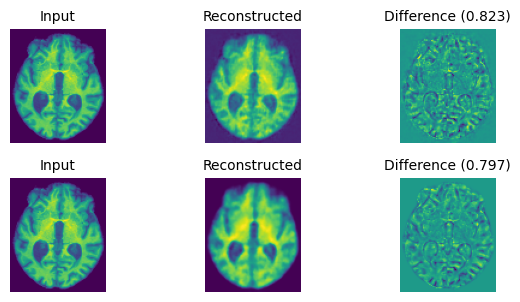

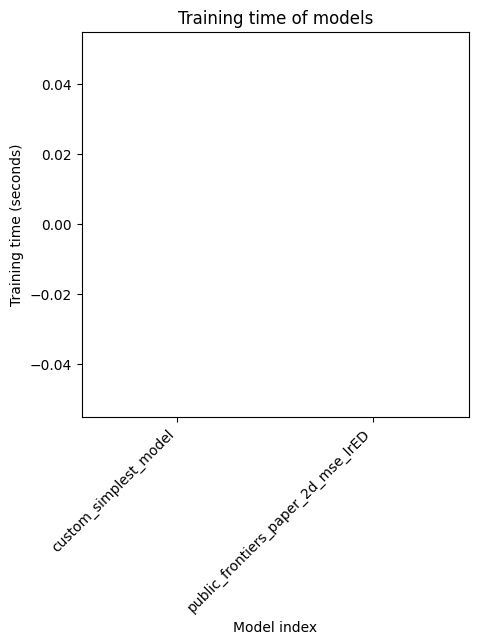

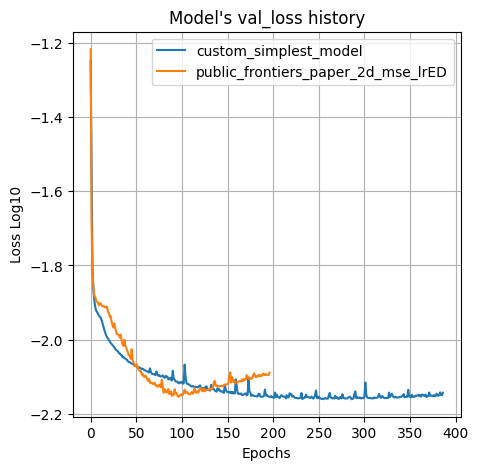

In [6]:
#models_list2d = [E5] #[A9,A6,A7] #[E,E2] #, B0, B1, B2]
#models_list = models_list2d

#models_list = [AE.open(r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_unsupervised_anomaly_2d_ssim\epoch_166")]



if 'models_list' in locals(): # if the variable exists
    images, latent, titles = compare_models_reconstruction(brain_scan_id=0, models_list=models_list, test=groups["CN"], loss=SSIM) # remember to update options [test, test2d]
    #print(latent)
    plot_images(images, dimensions=(20,3), fig_size=(6, 30), titles=titles, top_title="")
    
    plot_models_training_time(models_list, fig_size=(5,5))
    compare_models_loss_history(models_list, log10=True, fig_size=(5,5))

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\kiran\anaconda3\Lib\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\kiran\anaconda3\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\kiran\anaconda3\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\kiran\anaconda3\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\kiran\anacon

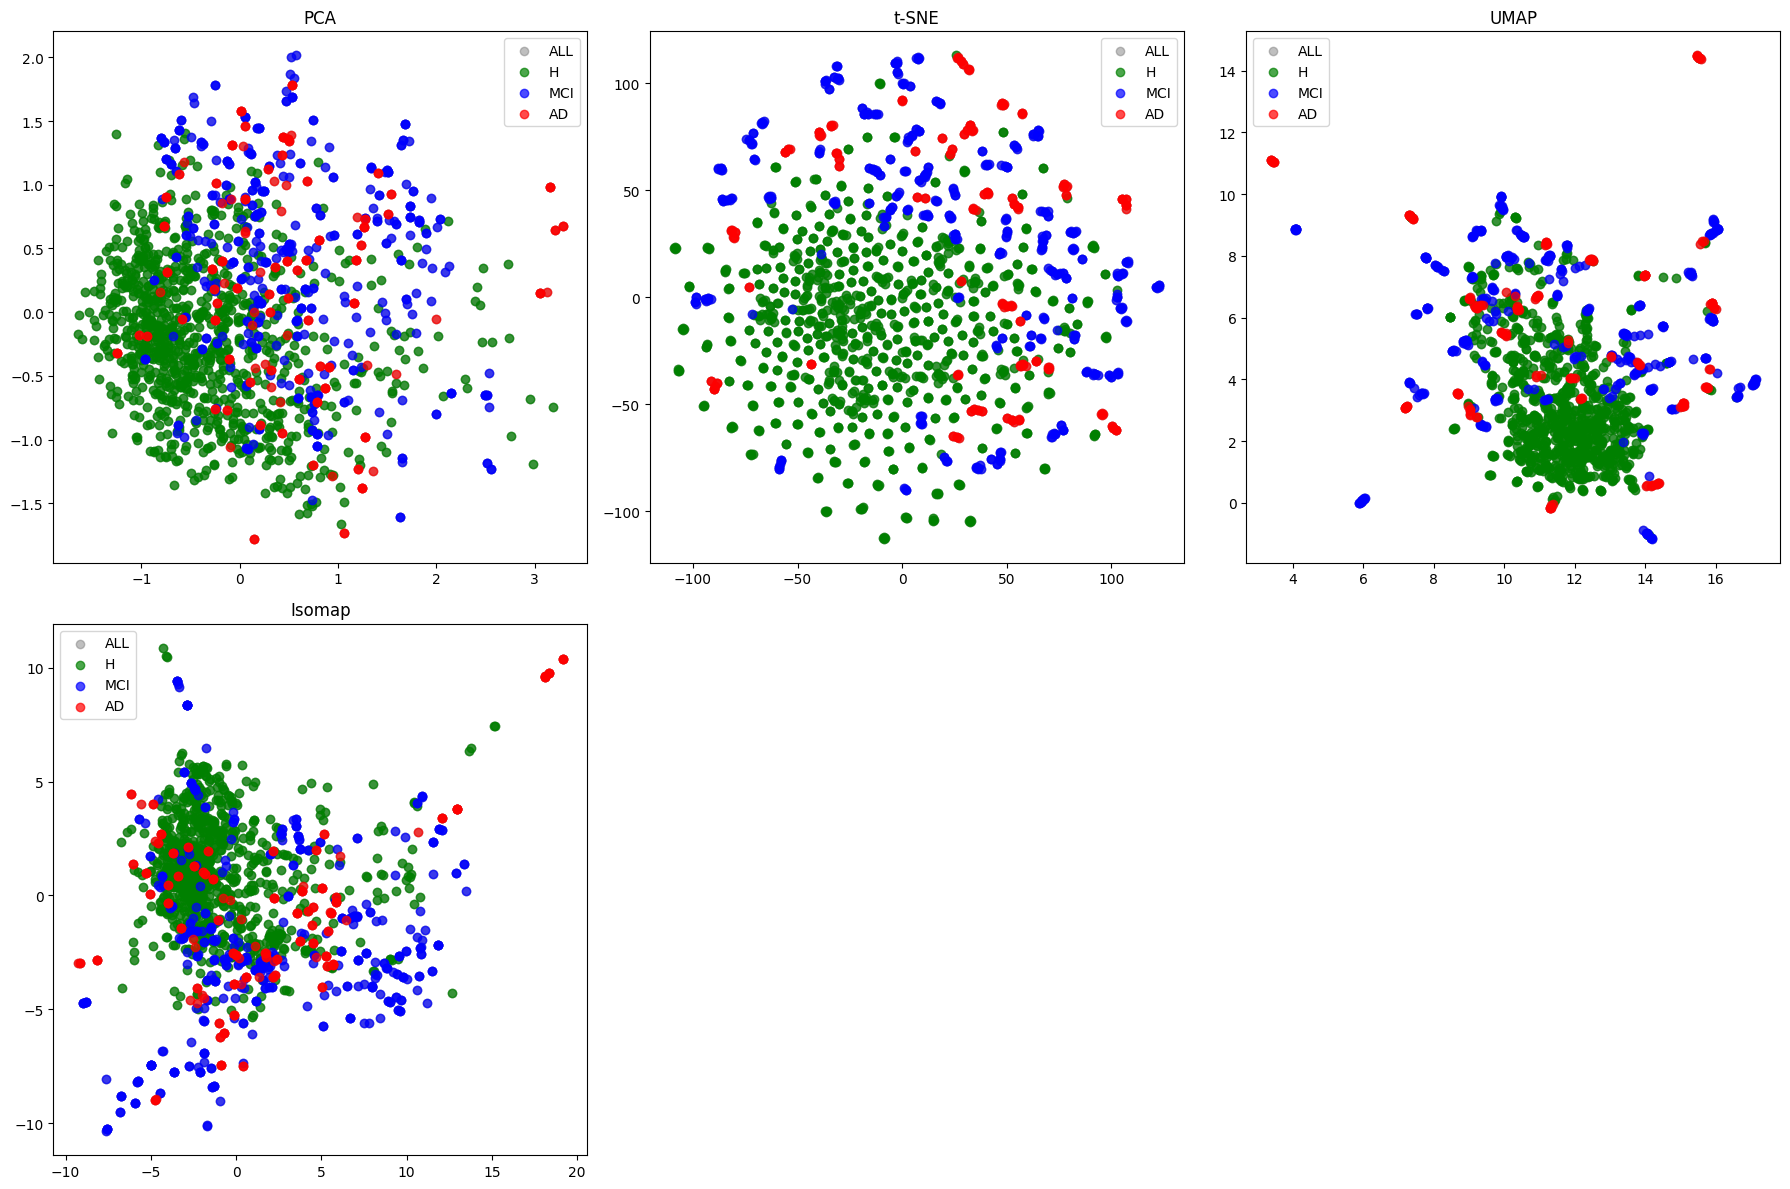

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


c:\Users\kiran\anaconda3\Lib\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\kiran\anaconda3\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\kiran\anaconda3\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\kiran\anaconda3\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\kiran\anacon

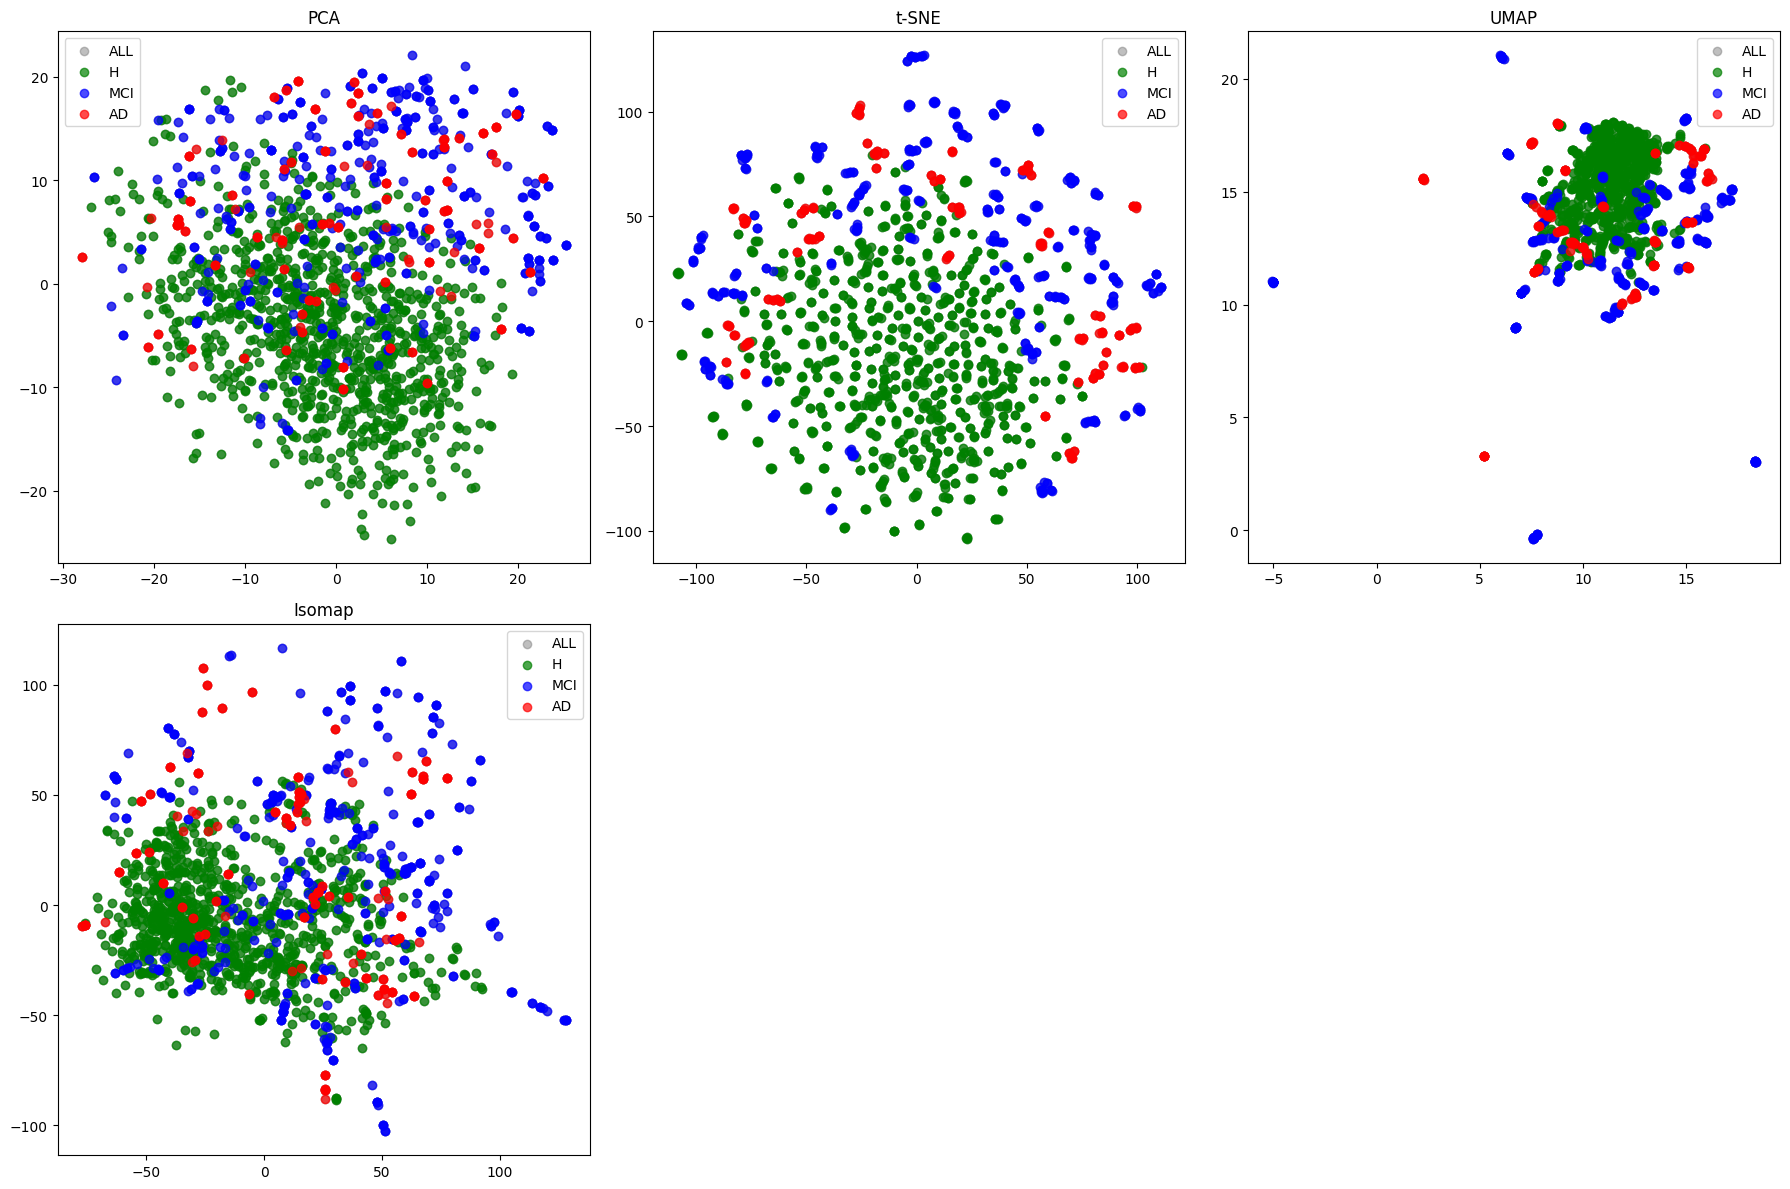

In [4]:
# simply add .vae_mdoel = False to your models.. then it works
for m in models_list:
    plot_multiple_datasets( 
        model=m,
        plot_functions=["PCA", "TSNE", "UMAP", "ISOMAP"],
        datasets=[groups["CN"], groups["MCI"], groups["AD"]],
        labels=["H", "MCI", "AD"],
        colors=["green", "blue", "red"],
        titles=["PCA", "t-SNE", "UMAP", "Isomap"]
    )


In [ ]:
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

def plot_hierarchical_clustering(model, datasets, labels, colors, title="Hierarchical Clustering Dendrogram (truncated)"):
    
    # Combine all datasets for consistent scaling
    combined_data = np.concatenate(datasets, axis=0)
    
    # Standardize the data
    scaler = StandardScaler()
    combined_data_scaled = scaler.fit_transform(combined_data.reshape(-1, combined_data.shape[-1])).reshape(combined_data.shape)
    
    # Get the model's encoded representation
    if model.VAE_model:
        z_mean, z_std, z = model.encoder.predict(combined_data_scaled)
        latent = z_mean
    else:
        latent = model.encoder.predict(combined_data_scaled)
    
    n_clusters = len(labels)
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage="")
    new_labels = clustering.fit_predict(latent)

    # Reduce latent vectors to 2D for plotting
    #pca = PCA(n_components=2)
    #reduced = pca.fit_transform(latent)
    
    dim_red_2D = {
        "UMAP": lambda latent: umap.UMAP(n_components=2).fit_transform(latent), # random_state=42
    }
    
    points_2D = dim_red_2D["UMAP"](latent) # Loop through each plot function and dataset to plot
    linked = linkage(latent, method='ward') # Compute linkage matrix

    # Plot combined figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    axes = axes.flatten()
    plot_proj(points_2D, datasets, colors, labels, axes[0], "Natural clustering")
    #sns.scatterplot(ax=axes[0], x=reduced[:, 0], y=reduced[:, 1], hue=new_labels, palette="tab10")
    #axes[0].set_title("PCA Projection of Latent Vectors (Colored by Cluster)")

    # Dendrogram
    dendrogram(linked, truncate_mode='level', p=5, ax=axes[1])
    axes[1].set_title("Hierarchical Clustering Dendrogram (Truncated)")
    axes[1].set_xlabel("Sample Index")
    axes[1].set_ylabel("Distance")

    plt.tight_layout()
    plt.show()


def plot_multiple_datasets(model, plot_functions, datasets, labels, colors, titles=None):

    # Combine all datasets for consistent scaling
    combined_data = np.concatenate(datasets, axis=0)
    
    # Standardize the data
    scaler = StandardScaler()
    combined_data_scaled = scaler.fit_transform(combined_data.reshape(-1, combined_data.shape[-1])).reshape(combined_data.shape)
    
    # Get the model's encoded representation
    if model.VAE_model:
        z_mean, z_std, z = model.encoder.predict(combined_data_scaled)
        latent = z_mean
    else:
        latent = model.encoder.predict(combined_data_scaled)
    
    num_plots = len(plot_functions)
    num_rows = (num_plots + 2) // 3  # Arrange plots in rows, 3 per row
    fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows))
    axes = axes.flatten()
    
    dim_red_2D = {
        "PCA": lambda latent: PCA(n_components=2).fit_transform(latent),
        "TSNE": lambda latent: TSNE(n_components=2, perplexity=5).fit_transform(latent), # random_state=42
        "UMAP": lambda latent: umap.UMAP(n_components=2).fit_transform(latent), # random_state=42
        "ISOMAP": lambda latent: Isomap(n_components=2).fit_transform(latent)
    }
    
    # Loop through each plot function and dataset to plot
    for i, plot_func in enumerate(plot_functions):
        ax = axes[i]
        title = titles[i] if titles and len(titles) > i else plot_func
        points_2D = dim_red_2D[plot_func](latent)
        plot_proj(points_2D, datasets, colors, labels, ax, title)
        ax.legend()

    # add spectral clustering
    
    # Remove any unused subplots
    for j in range(num_plots, len(axes)):
        axes[j].axis('off')
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

def plot_proj(points_2D, datasets, colors, labels, ax, title):
    ax.scatter(points_2D[:, 0], points_2D[:, 1], color="gray", label="ALL", alpha=0.5)
    start_idx = 0
    for dataset, color, label in zip(datasets, colors, labels):
        end_idx = start_idx + len(dataset)
        ax.scatter(points_2D[start_idx:end_idx, 0], points_2D[start_idx:end_idx, 1], 
                   color=color, label=label, alpha=0.7)
        start_idx = end_idx

    ax.set_title(title)
    ax.legend()


"""
plot_multiple_datasets( 
    model=models_list4[1],
    plot_functions=[pPCA, pTSNE, pUMAP, pISOMAP, pENCODED],
    datasets=[AD, MCI, H],
    labels=["AD", "MCI", "H"],
    colors=["red", "green", "blue"],
    titles=["PCA", "t-SNE", "UMAP", "Isomap", "Encoded"]
)
"""

Models loaded successfully.
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


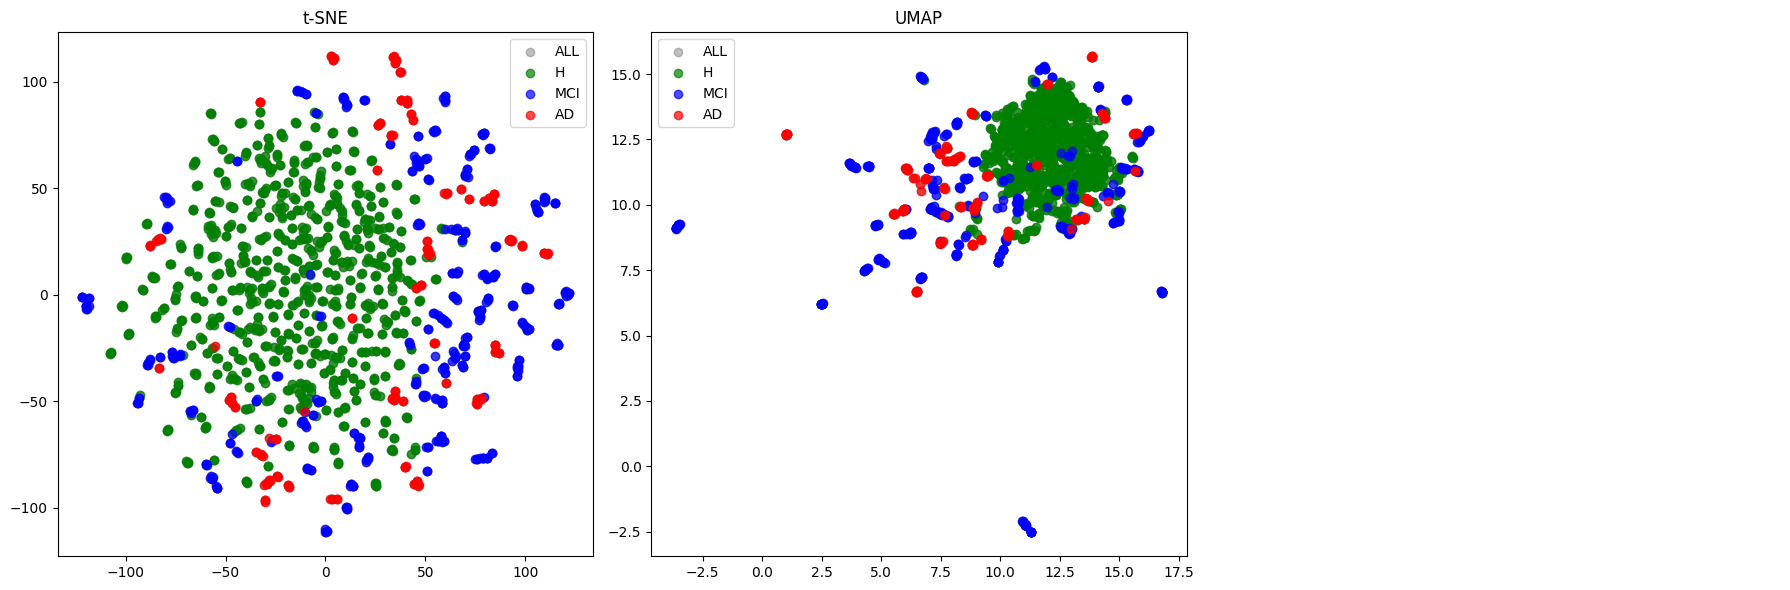

In [ ]:
model = AE.open(r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_frontiers_paper_2d_mse_lrED\epoch_197")
models_list = [model]

# simply add .vae_mdoel = False to your models.. then it works
for m in models_list:
    plot_multiple_datasets( 
        model=m,
        plot_functions=["TSNE", "UMAP", "SPECTRAL UMAP", "HIERARCHICAL UMAP"],
        datasets=[groups["CN"], groups["MCI"], groups["AD"]],
        labels=["H", "MCI", "AD"],
        colors=["green", "blue", "red"],
        titles=["t-SNE", "UMAP"]
    )

# r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\custom_simplest_model\epoch_387",
# r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_frontiers_paper_2d_mse_lrE\epoch_199",
# r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_frontiers_paper_2d_mse_lrED\epoch_197"


# plot of true clustering
# plot of spectral clustering
# plot of hierarchical clustering


Models loaded successfully.
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


KeyError: 'SPECTRAL UMAP'

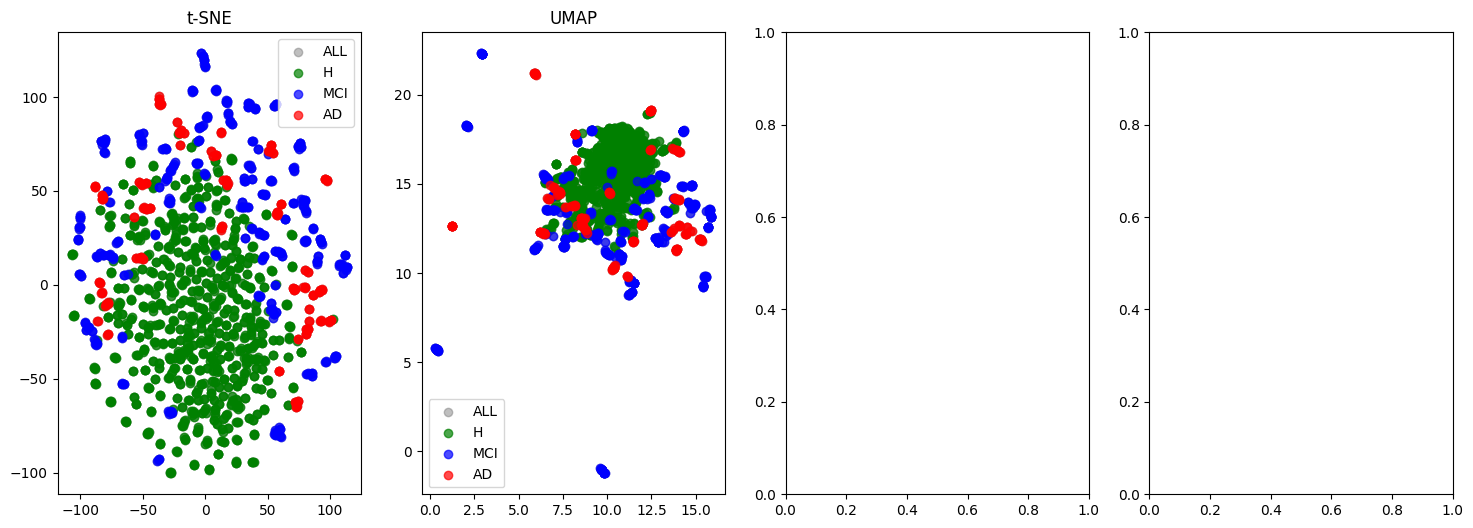

In [ ]:

def plot_proj(points_2D, datasets, colors, labels, ax, title):
    ax.scatter(points_2D[:, 0], points_2D[:, 1], color="gray", label="ALL", alpha=0.5)
    start_idx = 0
    for dataset, color, label in zip(datasets, colors, labels):
        end_idx = start_idx + len(dataset)
        ax.scatter(points_2D[start_idx:end_idx, 0], points_2D[start_idx:end_idx, 1], 
                   color=color, label=label, alpha=0.7)
        start_idx = end_idx

    ax.set_title(title)
    ax.legend()

model = AE.open(r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_frontiers_paper_2d_mse_lrED\epoch_197")

# - plot_multiple_datasets(model, plot_functions, datasets, labels, colors, titles=None)

models_list = [model]

plot_functions=["TSNE", "UMAP", "SPECTRAL UMAP", "HIERARCHICAL UMAP"]
datasets = [groups["CN"], groups["MCI"], groups["AD"]]
labels = ["H", "MCI", "AD"]
colors = ["green", "blue", "red"]
titles = ["t-SNE", "UMAP"]

combined_data = np.concatenate(datasets, axis=0)

# Get the model's encoded representation
if model.VAE_model:
    z_mean, z_std, z = model.encoder.predict(combined_data)
    latent = z_mean
else:
    latent = model.encoder.predict(combined_data)

num_plots = len(plot_functions)
fig, axes = plt.subplots(1, 4, figsize=(18, 6 * 1))
axes = axes.flatten()

points_2D_tsne = TSNE(n_components=2, perplexity=5).fit_transform(latent)
points_2D_umap = umap.UMAP(n_components=2).fit_transform(latent)

labels = SpectralClustering(n_clusters=3, affinity='rbf', gamma=1).fit_predict(points_2D_umap)

plot_proj(points_2D_tsne, datasets, colors, true_labels, axes[0], title="t-SNE w/ True Labels")
plot_proj(points_2D_umap, datasets, colors, labels, axes[1], title="UMAP w/ Spectral Clustering Labels")
plot_proj(points_2D_umap, datasets, colors, labels, axes[2], title="t-SNE w/ Spectral Clustering Labels")

    

Models loaded successfully.
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


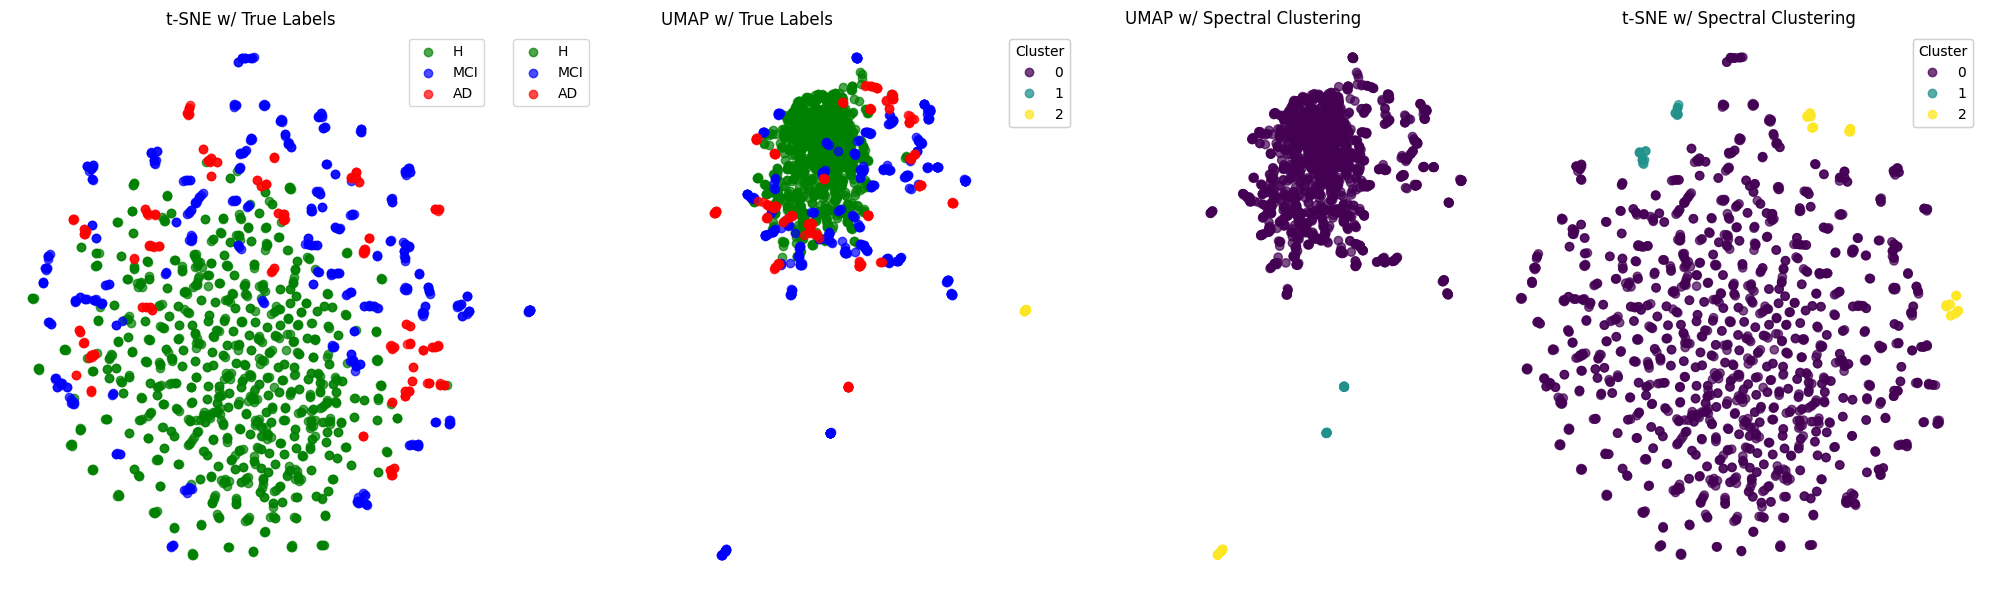

In [14]:
def plot_proj(points_2D, datasets, colors, labels, ax, title):
    ax.set_title(title)
    
    if isinstance(labels, list) and all(isinstance(label, str) for label in labels):
        # Assume per-dataset labels (e.g., "H", "MCI", "AD")
        start_idx = 0
        for dataset, color, label in zip(datasets, colors, labels):
            end_idx = start_idx + len(dataset)
            ax.scatter(points_2D[start_idx:end_idx, 0], points_2D[start_idx:end_idx, 1], 
                       color=color, label=label, alpha=0.7)
            start_idx = end_idx
        ax.legend()
    
    else:
        # Assume labels is a flat array of ints (e.g., spectral clustering)
        scatter = ax.scatter(points_2D[:, 0], points_2D[:, 1], c=labels, cmap="viridis", alpha=0.7)
        legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
        ax.add_artist(legend1)

    ax.axis("off")

model = AE.open(r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_frontiers_paper_2d_mse_lrED\epoch_197")

plot_functions = ["TSNE", "UMAP", "SPECTRAL UMAP", "HIERARCHICAL UMAP"]
datasets = [groups["CN"], groups["MCI"], groups["AD"]]
labels_true = ["H", "MCI", "AD"]
colors = ["green", "blue", "red"]

combined_data = np.concatenate(datasets, axis=0)

# Get latent representation
if model.VAE_model:
    z_mean, z_std, z = model.encoder.predict(combined_data)
    latent = z_mean
else:
    latent = model.encoder.predict(combined_data)

fig, axes = plt.subplots(1, 4, figsize=(20, 6))

points_2D_tsne = TSNE(n_components=2, perplexity=5).fit_transform(latent)
points_2D_umap = umap.UMAP(n_components=2).fit_transform(latent)

labels_spectral = SpectralClustering(n_clusters=3, affinity='rbf', gamma=1).fit_predict(points_2D_umap)

# Plot
plot_proj(points_2D_tsne, datasets, colors, labels_true, axes[0], title="t-SNE w/ True Labels")
plot_proj(points_2D_umap, datasets, colors, labels_true, axes[1], title="UMAP w/ True Labels")
plot_proj(points_2D_umap, datasets, colors, labels_spectral, axes[2], title="UMAP w/ Spectral Clustering")
plot_proj(points_2D_tsne, datasets, colors, labels_spectral, axes[3], title="t-SNE w/ Spectral Clustering")

plt.tight_layout()
plt.show()


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


NameError: name 'dendrogram' is not defined

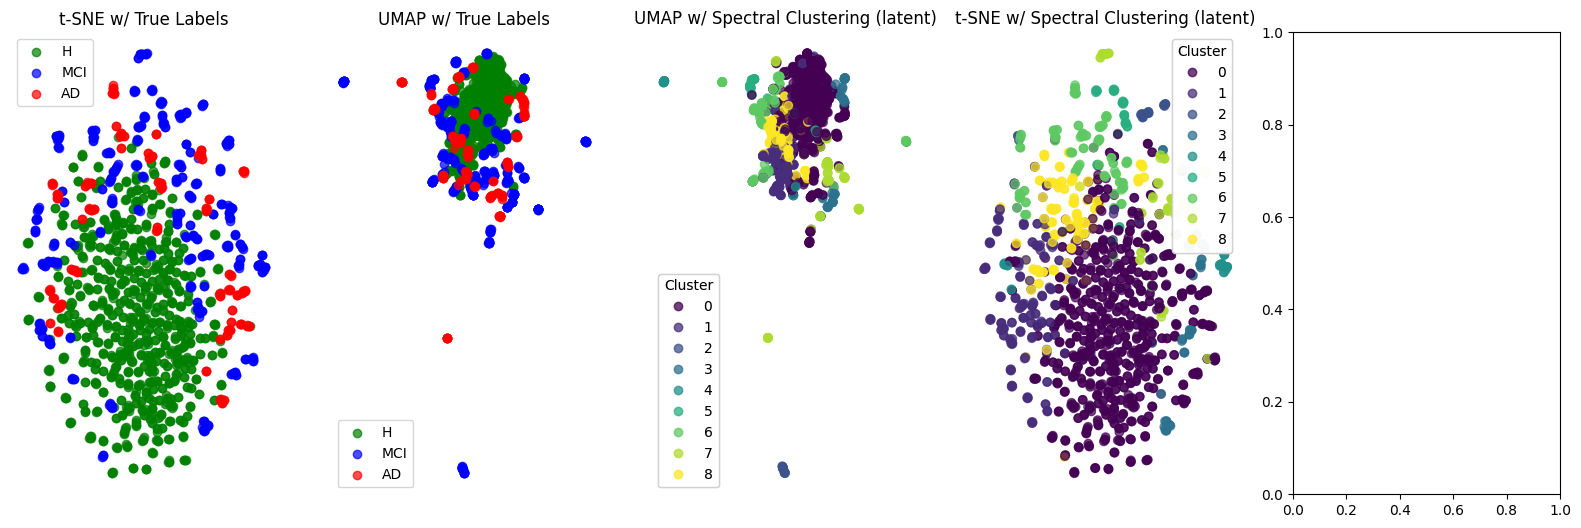

In [ ]:

fig, axes = plt.subplots(1, 5, figsize=(20, 6))

# Get the latent representation
if model.VAE_model:
    z_mean, z_std, z = model.encoder.predict(combined_data)
    latent = z_mean
else:
    latent = model.encoder.predict(combined_data)

# 2D UMAP and t-SNE projections of the latent space
points_2D_umap = umap.UMAP(n_components=2).fit_transform(latent)
points_2D_tsne = TSNE(n_components=2, perplexity=5).fit_transform(latent)

# Cluster ON the latent space, not the UMAP
#labels_spectral = SpectralClustering(n_clusters=3, affinity='rbf', gamma=1).fit_predict(latent)
#from sklearn.cluster import SpectralClustering

labels_spectral = SpectralClustering(n_clusters=9,affinity='nearest_neighbors',n_neighbors=25,assign_labels='kmeans',random_state=42).fit_predict(latent)
#labels_spectral = SpectralClustering(n_clusters=3,affinity='nearest_neighbors',n_neighbors=30,assign_labels='cluster_qr',random_state=42).fit_predict(latent)
#kmeans, 'discretize', 'cluster_qr']
# Plot projections
plot_proj(points_2D_tsne, datasets, colors, labels_true, axes[0], title="t-SNE w/ True Labels")
plot_proj(points_2D_umap, datasets, colors, labels_true, axes[1], title="UMAP w/ True Labels")
plot_proj(points_2D_umap, datasets, colors, labels_spectral, axes[2], title="UMAP w/ Spectral Clustering (latent)")
plot_proj(points_2D_tsne, datasets, colors, labels_spectral, axes[3], title="t-SNE w/ Spectral Clustering (latent)")

clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
dendrogram(linkage(latent, method='ward'), truncate_mode='level', p=5)


plt.tight_layout()
plt.show()




#clustering_metric(dim_red_latent_all_runs[i], pred_labels[i], true_labels)
def Cluster_accuracy(data, labels, true_labels):
    from sklearn.metrics import accuracy_score
    from scipy.optimize import linear_sum_assignment
    import numpy as np

    def cluster_accuracy(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        D = max(y_pred.max(), y_true.max()) + 1
        cost_matrix = np.zeros((D, D), dtype=np.int64)

        for i in range(len(y_pred)):
            cost_matrix[y_pred[i], y_true[i]] += 1

        row_ind, col_ind = linear_sum_assignment(cost_matrix.max() - cost_matrix)
        total = sum([cost_matrix[r, c] for r, c in zip(row_ind, col_ind)])
        return total / len(y_pred)

    acc = cluster_accuracy(true_labels, labels)
    print(f"Cluster match accuracy: {acc:.2f}")
    return acc

group_labels = {"CN": 0, "AD": 1, "MCI": 2}
metric_results = []
true_labels = []

for label, image in groups.items():
    true_labels.extend([group_labels[label]] * image.shape[0])

Cluster_accuracy(points_2D_tsne, labels_spectral, true_labels)

Models loaded successfully.
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


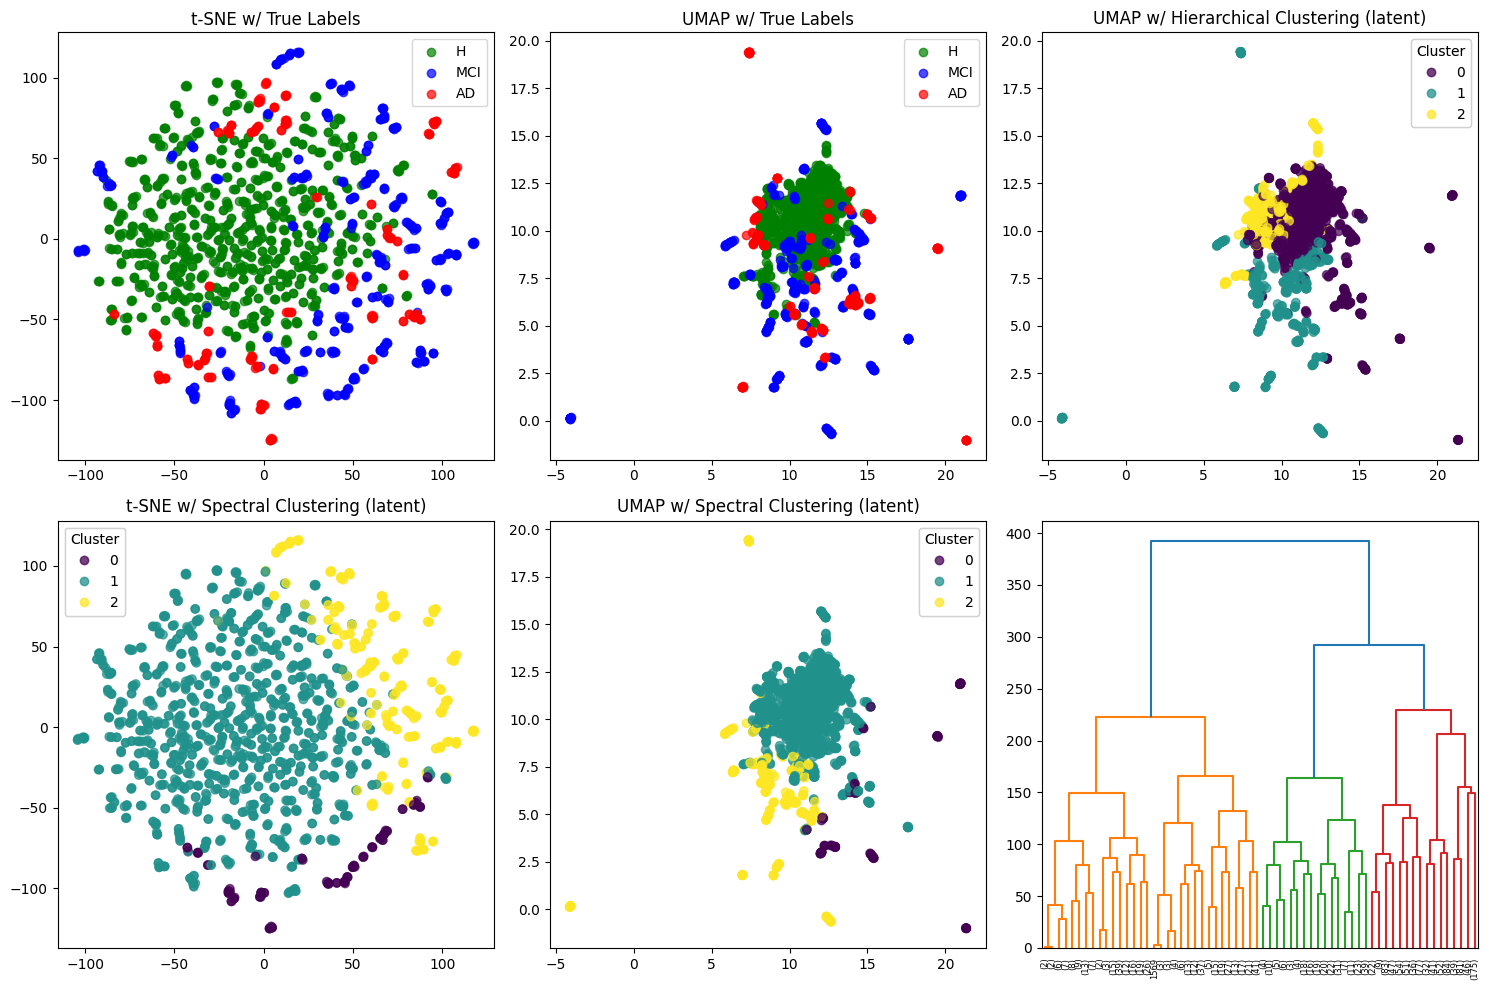


Spectral Clustering Accuracy:
Cluster match accuracy: 0.70

Hierarchical Clustering Accuracy:
Cluster match accuracy: 0.57


0.5685534591194968

In [106]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import SpectralClustering, AgglomerativeClustering
from sklearn.manifold import TSNE
import umap
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment

def plot_proj(points_2D, datasets, colors, labels, ax, title):
    ax.set_title(title)
    
    if isinstance(labels, list) and all(isinstance(label, str) for label in labels):
        # Assume per-dataset labels (e.g., "H", "MCI", "AD")
        start_idx = 0
        for dataset, color, label in zip(datasets, colors, labels):
            end_idx = start_idx + len(dataset)
            ax.scatter(points_2D[start_idx:end_idx, 0], points_2D[start_idx:end_idx, 1], 
                       color=color, label=label, alpha=0.7)
            start_idx = end_idx
        ax.legend()
    
    else:
        # Assume labels is a flat array of ints (e.g., spectral clustering)
        scatter = ax.scatter(points_2D[:, 0], points_2D[:, 1], c=labels, cmap="viridis", alpha=0.7)
        legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
        ax.add_artist(legend1)

    #ax.axis("off")

# Define the cluster accuracy function
def Cluster_accuracy(data, labels, true_labels):
    def cluster_accuracy(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        D = max(y_pred.max(), y_true.max()) + 1
        cost_matrix = np.zeros((D, D), dtype=np.int64)
        for i in range(len(y_pred)):
            cost_matrix[y_pred[i], y_true[i]] += 1
        row_ind, col_ind = linear_sum_assignment(cost_matrix.max() - cost_matrix)
        total = sum([cost_matrix[r, c] for r, c in zip(row_ind, col_ind)])
        return total / len(y_pred)

    acc = cluster_accuracy(true_labels, labels)
    print(f"Cluster match accuracy: {acc:.2f}")
    return acc

#url = r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_frontiers_paper_2d_mse\epoch_215"
#url2 = r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_frontiers_paper_2d_mse_lrED\epoch_197"
#url = r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_unsupervised_anomaly_2d_mse\epoch_256"
url = r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_unsupervised_anomaly_2d_ssim\epoch_166"
model = AE.open(url)

plot_functions = ["TSNE", "UMAP", "SPECTRAL UMAP", "HIERARCHICAL UMAP"]
datasets = [groups["CN"], groups["MCI"], groups["AD"]]
labels_true = ["H", "MCI", "AD"]
colors = ["green", "blue", "red"]

combined_data = np.concatenate(datasets, axis=0)

# Get the model's encoded representation
if model.VAE_model:
    z_mean, z_std, z = model.encoder.predict(combined_data)
    latent = z_mean
else:
    latent = model.encoder.predict(combined_data)

# 2D UMAP and t-SNE projections of the latent space
n_clusters = 3
points_2D_umap = umap.UMAP(n_components=2).fit_transform(latent)
points_2D_tsne = TSNE(n_components=2, perplexity=5).fit_transform(latent)
labels_spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=25, assign_labels='kmeans', random_state=42).fit_predict(latent)
#labels_spectral = SpectralClustering(n_clusters=n_clusters, affinity='rbf', gamma=0.1).fit_predict(latent)#, random_state=42).fit_predict(latent)
labels_hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit_predict(latent)

# Plot projections
scale = 5
fig, axes = plt.subplots(2, 3, figsize=(3*scale, 2*scale))
plot_proj(points_2D_tsne, datasets, colors, labels_true, axes[0][0], title="t-SNE w/ True Labels")
plot_proj(points_2D_umap, datasets, colors, labels_true, axes[0][1], title="UMAP w/ True Labels")
plot_proj(points_2D_umap, datasets, colors, labels_hierarchical, axes[0][2], title="UMAP w/ Hierarchical Clustering (latent)")
plot_proj(points_2D_tsne, datasets, colors, labels_spectral, axes[1][0], title="t-SNE w/ Spectral Clustering (latent)")
plot_proj(points_2D_umap, datasets, colors, labels_spectral, axes[1][1], title="UMAP w/ Spectral Clustering (latent)")

# Dendrogram for Hierarchical Clustering
dendrogram(linkage(latent, method='ward'), truncate_mode='level', p=5)

plt.tight_layout()
plt.show()

# Calculate cluster accuracy for both clustering methods
group_labels = {"CN": 0, "AD": 1, "MCI": 2}
true_labels = []
for label, image in groups.items():
    true_labels.extend([group_labels[label]] * image.shape[0])

# Cluster accuracy for Spectral Clustering and Hierarchical Clustering
print("\nSpectral Clustering Accuracy:")
Cluster_accuracy(points_2D_tsne, labels_spectral, true_labels)

print("\nHierarchical Clustering Accuracy:")
Cluster_accuracy(points_2D_tsne, labels_hierarchical, true_labels)


In [102]:
labels_true = ["CN", "MCI", "AD"]

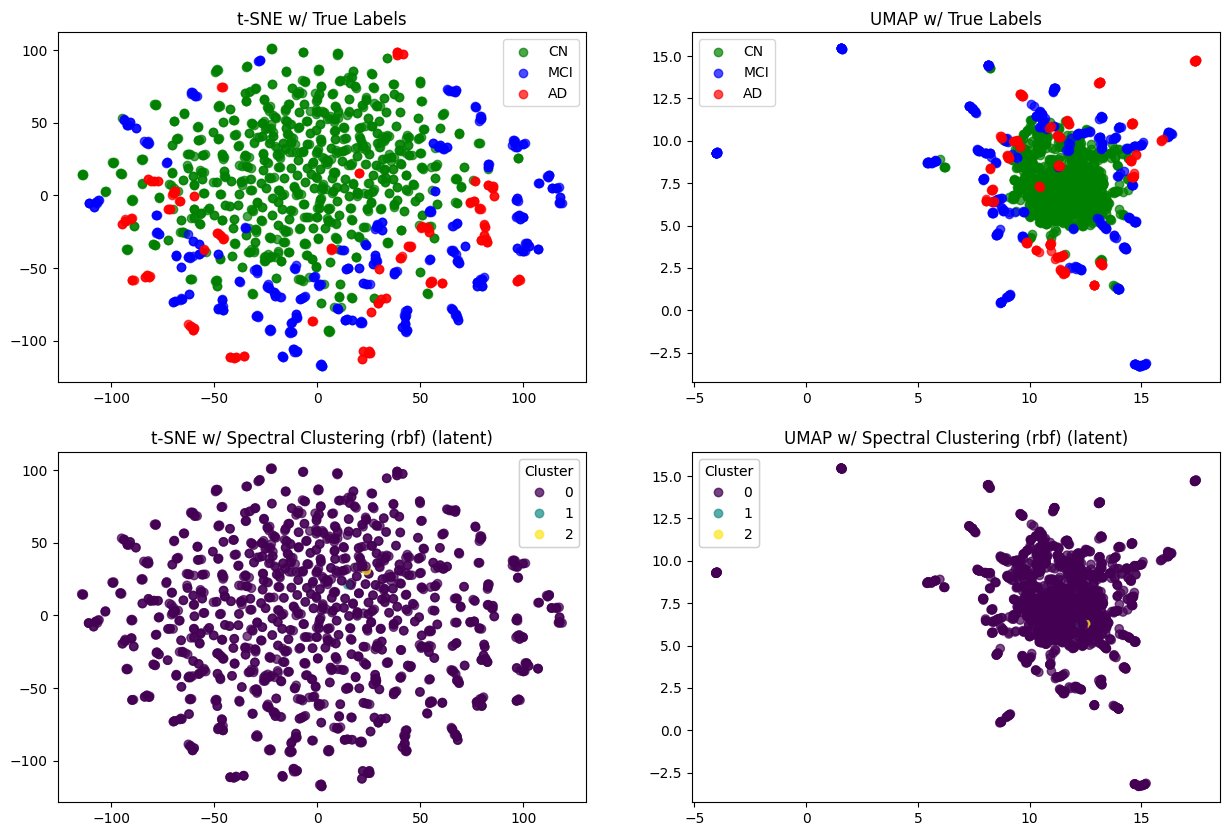

In [103]:
# Plot projections
scale = 5
fig, axes = plt.subplots(2, 2, figsize=(3*scale, 2*scale))
plot_proj(points_2D_tsne, datasets, colors, labels_true, axes[0][0], title="t-SNE w/ True Labels")
plot_proj(points_2D_umap, datasets, colors, labels_true, axes[0][1], title="UMAP w/ True Labels")
#plot_proj(points_2D_umap, datasets, colors, labels_hierarchical, axes[0][2], title="UMAP w/ Hierarchical Clustering (latent)")
plot_proj(points_2D_tsne, datasets, colors, labels_spectral, axes[1][0], title="t-SNE w/ Spectral Clustering (rbf) (latent)")
plot_proj(points_2D_umap, datasets, colors, labels_spectral, axes[1][1], title="UMAP w/ Spectral Clustering (rbf) (latent)")
